> # Image classifiction

In this part of the project we are going to build neural networks of two kinds
1. CNN from scratch
2. Using VGG-16 with transfer learning implementation

## The ModelUse() class

This class handle all the model creation and fitting of the CNN and VGG, and help up change a lot of things in the structures of the neural network with using the same function. The main methods are:

1. `crate_image_gens()` - creating the ImageDataGenerators for the image flows from the filtered directory.
2. `genarate_model()` - creating the model structure and compiling it.
3. `arrange_by_tags()` - split the data from a given source folder to the correct folder format (split to train and test and inside them to the tags). we will use it in the final project.
4. `predict_image_with_cnn()` - using the CNN model that we have build to make a prediction. build for softmax and sigmoid and showing defferent prints to each one.
5. `cnn_model()` - creating a model fit if the `.h5` of this model name does not exists. if it is exists, loading the model.
6. `vgg16_transfer_learning_model()` - creating a neural network using the vgg-16 model with transfer learning method. 



In [119]:
from re import A
import os
import zipfile
from shutil import copy , rmtree
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread 

import pandas as pd
import numpy as np
import random



# keras imports
from keras.utils import load_img , img_to_array
from keras import layers
from keras import Model
from keras.optimizers import RMSprop , SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


# imports for vgg model
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np


%matplotlib inline

class ModelUse():
        def __init__(
                self,

                
                prediction_keys : list, # list of the tags this model know
                filtered_dir : str,
                data_src_dir : str = None, # source directory of the image data files
                 # destination directory of the image files
                train_split_size : int = None, # how many image going to the train data
                rearange_data : bool = True, # use only for the first time to transfer from the source to the destination dirs
                image_input_shape = (150,150,3),
                target_size = (150,150),
                output_activation : str = 'softmax',
                show_logs : bool = True, # manage the logs along the way
                use_padding : str = "valid",
                use_strides = (1,1),

                use_aug : bool = False,
                rotation_range : float = 30,
                width_shift_range : float =0.2,
                height_shift_range : float =0.2,
                zoom_range : float =0.2,
                horizontal_flip : bool = True,


                # neural network settings
                k_size : int = 3,
                conv2_act_func : list = ["relu" , "relu" , "relu"],
                conv2_node_number : list = [16 , 32 , 64],


                use_dropout : bool = False, # decide if you want to add dropout layer
                dropout_rate : float = 0.5, # if there is a dropout layer, decide the dropout rate

                optimizer = None, # the funciton that get send to the compile of the model
                learning_rate : float = 0.001,
                loss_function : any = 'binary_crossentropy',
                train_batch_size : int = 20,
                test_batch_size : int = 20,
                image_class_mode : str = 'categorical',
                existing_model_path = None, # is there is a model in a .h5 file, we can load it instead of creating NN again
                epoch_number : int = 10, 
                verbose : int = 2, # logs of the apoch proccess

                model_name : str = "my_model", # the name of the new modle that saved ( my_model.h5 )
                
                create_cnn : bool = True,
                create_vgg : bool = True,
                use_transfer_learning : bool = True,
                save_model : bool = False,

                
        ):
                
                try:
                        self.existing_model_path = os.path.join(os.getcwd() , existing_model_path)
                except:
                        self.existing_model_path = None
                self.rearange_data = rearange_data
                prediction_keys.sort()
                self.prediction_keys = prediction_keys
                self.data_dict = {}
                for key in self.prediction_keys:
                        self.data_dict[key] = []
                self.image_input_shape = image_input_shape
                self.output_activation = output_activation
                self.show_log = show_logs
                self.use_padding = use_padding
                self.use_strides = use_strides 

                self.use_aug = use_aug
                self.rotation_range = rotation_range 
                self.width_shift_range = width_shift_range
                self.height_shift_range = height_shift_range
                self.zoom_range = zoom_range
                self.horizontal_flip = horizontal_flip

                

                self.k_size = k_size
                self.conv2_act_function = conv2_act_func
                self.conv2_node_number = conv2_node_number

                self.use_dropout = use_dropout
                self.dropout_rate = dropout_rate

                self.learning_rate = learning_rate
                if optimizer == None:
                        self.use_optimizer = RMSprop(learning_rate=learning_rate)
                else:
                        self.use_optimizer = optimizer
                self.loss_function = loss_function
                self.epoch_number = epoch_number
                self.data_src_dir = data_src_dir
                self.filtered_dir = filtered_dir
                self.train_split_size = train_split_size
                self.image_target_size = target_size # i.e. 150X150 (150,150)
                self.train_batch_size = train_batch_size
                self.test_batch_size = test_batch_size
                self.image_class_mode = image_class_mode
                self.verbose = verbose
                self.model_name = model_name
                self.save_model = save_model

                if create_cnn:
                  self.model = self.cnn_model()

                if create_vgg:
                  try:
                    self.use_transfer_learning = use_transfer_learning
                    self.vgg_tl_model = self.vgg16_transfer_learning_model()
                  except Exception as e:
                    print("Something went wrong with building the vgg model" , e) # 


        def decode_results(self , results):
                          
          pred_dict = {}

          for key , pred in zip(self.prediction_keys , results[0]):
                  pred_dict[key] = pred
          

          return pred_dict


        def create_image_gens(self , rescale_factor = 1./255 , datagen_mean : any = False , target_size = False):

                train_dir = os.path.join(self.filtered_dir , "train")
                test_dir = os.path.join(self.filtered_dir , "test")

                if not os.path.exists(train_dir) or not os.path.exists(test_dir):
                        return


                # All images will be rescaled by 1./255
                if self.use_aug:
                  train_datagen = ImageDataGenerator(rescale=rescale_factor,
                                                     rotation_range=self.rotation_range,
                                                      width_shift_range=self.width_shift_range,
                                                      height_shift_range=self.height_shift_range,
                                                      zoom_range=self.zoom_range,
                                                      horizontal_flip=self.horizontal_flip)
                  
                  test_datagen = ImageDataGenerator(rescale=rescale_factor)

                else:
                  train_datagen = ImageDataGenerator(rescale=rescale_factor)
                  test_datagen = ImageDataGenerator(rescale=rescale_factor)


                if datagen_mean:
                        train_datagen.mean = datagen_mean
                        test_datagen.mean = datagen_mean



                  
                if target_size:
                  # Flow training images in batches of 20 using train_datagen generator
                  train_gen = train_datagen.flow_from_directory(
                          train_dir,  # This is the source directory for training images
                          target_size=target_size,  # All images will be resized to 150x150
                          batch_size=self.train_batch_size,
                          class_mode=self.image_class_mode
                          )


                  # Flow validation images in batches of 20 using val_datagen generator
                  test_gen = test_datagen.flow_from_directory(
                          test_dir,
                          target_size=target_size,
                          batch_size=self.test_batch_size,
                          class_mode=self.image_class_mode
                          )

                else:
                  # Flow training images in batches of 20 using train_datagen generator
                  train_gen = train_datagen.flow_from_directory(
                          train_dir,  # This is the source directory for training images
                          target_size=self.image_target_size,  # All images will be resized to 150x150
                          batch_size=self.train_batch_size,
                          class_mode=self.image_class_mode
                          )


                  # Flow validation images in batches of 20 using val_datagen generator
                  test_gen = test_datagen.flow_from_directory(
                          test_dir,
                          target_size=self.image_target_size,
                          batch_size=self.test_batch_size,
                          class_mode=self.image_class_mode
                          )

                return train_gen , test_gen

        def genarate_model(self):
                """
                  This method define the NN structure
                """ 
                # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
                # the three color channels: R, G, and B
                img_input = layers.Input(shape=self.image_input_shape)

                first = True
                # This loop use two lists of values to create the layers in this model
                # in a dynamic way, by adding Conv2D layer and MaxPool layer according to 
                # current activation function and number of nodes given in the lists
                for act_func , node_number in zip(self.conv2_act_function , self.conv2_node_number):
                        if first:        
                                x = layers.Conv2D(node_number, self.k_size, activation=act_func , padding = self.use_padding)(img_input)
                                first = False
                        else:
                                x = layers.Conv2D(node_number, self.k_size, activation=act_func , padding = self.use_padding)(x)                
                        x = layers.MaxPooling2D(2)(x)
                        

                # Flatten feature map to a 1-dim tensor so we can add fully connected layers
                x = layers.Flatten()(x)

                # Create a fully connected layer with ReLU activation and 512 hidden units
                x = layers.Dense(512, activation='relu')(x)

                if self.use_dropout:
                        x = layers.Dropout(self.dropout_rate)(x)
                
                
                if self.output_activation == "sigmoid":
                        output_lenght = 1
                elif self.output_activation == "softmax":
                        output_lenght = len(self.prediction_keys)
                
                output = layers.Dense(output_lenght , activation=self.output_activation)(x)

                # Create model:
                # input = input feature map
                # output = input feature map + stacked convolution/maxpooling layers + fully 
                # connected layer + sigmoid output layer
                model = Model(img_input, output)

                if self.show_log:
                        model.summary()

                model.compile(loss=self.loss_function ,optimizer=self.use_optimizer , metrics=['acc'])

                self.model = model
                return model

        def arrange_by_tags(self):
        
                if os.path.exists(self.filtered_dir):
                        rmtree(self.filtered_dir)

                os.mkdir(self.filtered_dir)
                os.mkdir(os.path.join(self.filtered_dir , "train"))
                os.mkdir(os.path.join(self.filtered_dir , "test"))
                

                img_file_list = os.listdir(self.data_src_dir)

                for img in img_file_list:
                        for key in list(self.data_dict.keys()):
                                if key in img:
                                        self.data_dict[key].append(img)


                train_images = {}
                test_images = {}

                if self.train_split_size == None:
                        # half of the size of the min length
                        length_of_data_list = [len(self.data_dict[key]) for key in list(self.data_dict.keys())]
                        self.train_split_size = round(min(length_of_data_list)/2)



                for key in list(self.data_dict.keys()):
                        train_images[key] = self.data_dict[key][:self.train_split_size]
                        test_images[key] = self.data_dict[key][self.train_split_size:]


                # copy the files from the source dir to the filtered dir
                for key in list(train_images.keys()):

                        # copy all the train files from the source dir to the filtered dir
                        for filename in train_images[key]:

                                if not os.path.exists(f"{self.filtered_dir}\\train\\{key}"):
                                        path = os.path.join(f"{self.filtered_dir}\\train", key)
                                        
                                        os.mkdir(path)

                                copy(f"{self.data_src_dir}\\{filename}" , f"{self.filtered_dir}\\train\\{key}\\{filename}")
                        
                        # copy all the test files from the source dir to the filtered dir
                        for filename in test_images[key]:
                                if not os.path.exists(f"{self.filtered_dir}/test/{key}"):
                                        os.mkdir(f"{self.filtered_dir}/test/{key}")

                                copy(f"{self.data_src_dir}/{filename}" , f"{self.filtered_dir}/test/{key}/{filename}")

                # print the length of all the files for a certain tag
                if self.show_log:
                        for key in list(self.data_dict.keys()):
                                print(f"list length of {key} : " , len(self.data_dict[key]))
                 
        def predict_image_with_cnn(self ,  img_path  , model = None , display_image : bool = False):

                if display_image:
                  #There is an interpolation method to match the source size with the target size
                  #image loaded in PIL (Python Imaging Library)
                  img = image.load_img(img_path,color_mode='rgb', target_size=(224, 224))
                  display(img)

                if model==None:
                        model = self.model
                
                img = load_img(img_path, target_size=self.image_target_size)  
                x = img_to_array(img)  
                x = x.reshape((1,) + x.shape)

                # Rescale by 1/255
                x /= 255

                # Let's run our image through our network, thus obtaining all
                # intermediate representations for this image.
                successive_feature_maps = model.predict(x)
                
                if len(successive_feature_maps[0]) == 1:
                  return successive_feature_maps[0]


                return self.decode_results(successive_feature_maps)
        def predict_image_with_vgg(self, img_path , display_image : bool = False , top_n : int = 5):

                
                if display_image:
                  #There is an interpolation method to match the source size with the target size
                  #image loaded in PIL (Python Imaging Library)
                  img = image.load_img(img_path,color_mode='rgb', target_size=(224, 224))
                  display(img)

                # Converts a PIL Image to 3D Numy Array
                x = image.img_to_array(img)
                x.shape
                # Adding the fouth dimension, for number of images
                x = np.expand_dims(x, axis=0)

                # mean centering with respect to Image
                x = preprocess_input(x)
                features = weather_use.vgg_tl_model.predict(x)


                if not self.use_transfer_learning:
                  return decode_predictions(features)
                else:
                  return self.decode_results(features)

        def cnn_model(self): 

                model_filename = os.path.join(os.getcwd() , ".".join([self.model_name , "h5"])) 
                if os.path.exists(model_filename):
                        print("Loading model from  " , model_filename)
                        self.model = load_model(model_filename)
                        return self.model
                        
                        
                print(f"Creating new model at {model_filename}...")


                if self.rearange_data:
                        self.arrange_by_tags()

                # dumb model
                our_model = self.genarate_model()
                
                # create generators
                train_generator , test_generator = self.create_image_gens()

                # training the model
                
                self.history = our_model.fit(
                        train_generator,
                        epochs=self.epoch_number,
                        validation_data=test_generator,
                        verbose=self.verbose
                )

                if self.save_model:
                  try:
                          print("Saving new model to " , model_filename )
                          our_model.save(model_filename)
                          self.existing_model_path = model_filename
                                  
                  except Exception as e:
                          print(e)

        
                self.model = our_model
                return our_model
                      
                 

        def vgg16_transfer_learning_model(self):

                
                
                if not self.use_transfer_learning:
                  print("Using VGG-16 without Transfer Learning")
                  model = VGG16(input_shape=(224, 224, 3))
                  self.vgg_tl_model = model
                  return model

                ## implament transfer learning
                print("Using VGG-16 with Transfer Learning")
                # load model
                model = VGG16(include_top=False, input_shape=(224, 224, 3))
                
                # mark loaded layers as not trainable
                for layer in model.layers:
                        layer.trainable = False




                # add new classifier layers
                x = layers.GlobalMaxPool2D()(model.layers[-1].output)
                x = layers.Dense(512, activation=self.output_activation, kernel_initializer='he_uniform')(x)
                # x = layers.Dense(20, activation=self.output_activation)(x)





                if self.use_dropout:
                  x = layers.Dropout(self.dropout_rate)(x)

                output = layers.Dense(len(self.prediction_keys), activation=self.output_activation)(x)
                
                # define new model
                model = Model(inputs=model.inputs, outputs=output)

                # compile model
                model.compile(optimizer=self.use_optimizer, loss=self.loss_function , metrics=['accuracy'])

                if self.show_log:
                  print(model.summary())

                train_generator , test_generator = self.create_image_gens(datagen_mean=[123.68, 116.779, 103.939] ,target_size=(224,224))

                
                es = EarlyStopping(monitor='val_accuracy', mode='max', patience=15,  restore_best_weights=True)


                self.vgg_history = model.fit(
                    train_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_data = test_generator , 
                    epochs=self.epoch_number, 
                    verbose=self.verbose,
                    callbacks=[es],
                    )


                self.vgg_tl_model = model

                return model



def our_plot(history , title : str =""):

  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  try:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
  except:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc , "r" , label = "accuracy")
  plt.plot(epochs, val_acc , "b", label = "validation accuracy")
  plt.title(f"{title.upper()} accuracy vs number of epochs")
  plt.xlabel("number of epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss , "r" , label = "loss")
  plt.plot(epochs, val_loss , "b", label = "validation loss")
  plt.title(f"{title.upper()} loss vs number of epochs")
  plt.xlabel("number of epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()
  
  return acc[-1] , val_acc[-1]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filtered_dir_path = "/content/drive/MyDrive/intro-to-AI/hw/data_mining_project/image_iden/weather_filtered"

## 1. CNN model

# sapir add desc

hiper parameters:
```python
prediction_keys = ["rain" , "cloudy" , "shine" , "sunrise"],
conv2_act_func = ["relu" , "relu" , "relu"],
conv2_node_number = [16 , 32 , 64],
model_name=f"weather_model_{batch_size}",
train_split_size=150,
show_logs = True, # model architecture
output_activation="softmax",
optimizer=SGD(learning_rate=0.001, momentum=0.9),
epoch_number=10,
verbose=1,
test_batch_size=batch_size,
train_batch_size=batch_size,
```


In [103]:

batch_size = 20
weather_use = ModelUse(

      # data_src_dir=os.path.join(os.getcwd() , "hw\data_mining_project\image_iden\weather"),  
      rearange_data=False,
      train_split_size=150,
    
      filtered_dir=filtered_dir_path,

      prediction_keys = ["rain" , "cloudy" , "shine" , "sunrise"],
      conv2_act_func = ["relu" , "relu" , "relu"],
      conv2_node_number = [16 , 32 , 64],
      model_name=f"weather_model_{batch_size}",
      
      show_logs = False, # model architecture
      output_activation="softmax",
      optimizer=SGD(learning_rate=0.001, momentum=0.9),
      epoch_number=10,
      verbose=1,
      test_batch_size=batch_size,
      train_batch_size=batch_size,


      create_cnn = True,
      create_vgg = False,
      # use_transfer_learning = False,

      # loss_function = "categorical_crossentropy",



      )



In [57]:
acc , val_acc = our_plot(weather_use.history , title = "CNN")
print("accuracy: " , acc , ", validation accuracy:" , val_acc)

AttributeError: ignored

## Testing the model with Dall-E
We are going to test the model on random images of weather generated with the Dall-E app. By sending descriptions of weather, we are able to create images that the model did not see at all and print the model's predictions to this image.

image name: sunny.jpg


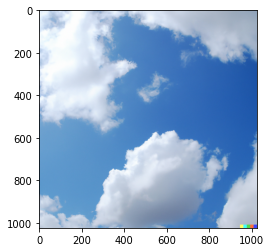

1/1 [==============================] - 0s 17ms/step
{'cloudy': 0.09434448, 'rain': 0.27682707, 'shine': 0.62871677, 'sunrise': 0.00011167606}
image name: cloudy.jpg
1/1 [==============================] - 0s 19ms/step
{'cloudy': 0.38584003, 'rain': 0.36766317, 'shine': 0.201971, 'sunrise': 0.044525854}
image name: sunrise.1.jpg
1/1 [==============================] - 0s 16ms/step
{'cloudy': 0.00041134868, 'rain': 0.0008595687, 'shine': 2.9311916e-06, 'sunrise': 0.99872607}
image name: sunrise.2.jpg
1/1 [==============================] - 0s 16ms/step
{'cloudy': 0.13103043, 'rain': 0.00546692, 'shine': 0.04158121, 'sunrise': 0.8219214}
image name: sunrise.3.jpg
1/1 [==============================] - 0s 16ms/step
{'cloudy': 0.005645997, 'rain': 0.002130202, 'shine': 7.445452e-05, 'sunrise': 0.99214923}
image name: rain.1.jpg
1/1 [==============================] - 0s 18ms/step
{'cloudy': 0.6102613, 'rain': 0.12325704, 'shine': 0.044880893, 'sunrise': 0.22160076}
image name: rain.2.png
1/1 [=

IsADirectoryError: ignored

In [29]:

dall_e_weather_images_folder = "/content/drive/MyDrive/intro-to-AI/hw/data_mining_project/image_iden/dall-e_images"
image_list = os.listdir(dall_e_weather_images_folder)
first = True
for image in image_list:
  try:
    print("image name:" , image)
    pred = weather_use.predict_image_with_cnn(
        img_path = os.path.join(dall_e_weather_images_folder , image),
        display_image = first,
        )
    first = False
    print(pred)
  except:
    pass

## 2. VGG-16 with transfer learning

the `ModelUse()` class that we have build is already creating the vgg model as dedault and we can use it to display its predictions

In [120]:


weather_use = ModelUse(
    
      filtered_dir='',
      prediction_keys = [],

      create_cnn = False,
      create_vgg = True,
      use_transfer_learning = False,


      )



Using VGG-16 without Transfer Learning


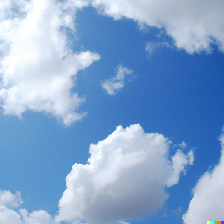

1/1 [==============================] - 0s 127ms/step
parachute  :  0.13595879
geyser  :  0.126974
flagpole  :  0.06870352
obelisk  :  0.044811387
volcano  :  0.040189877


In [113]:
dall_e_weather_images_folder = "/content/drive/MyDrive/intro-to-AI/hw/data_mining_project/image_iden/dall-e_images"
img_path = os.listdir(dall_e_weather_images_folder)[0]
img_path = os.path.join(dall_e_weather_images_folder , img_path)

pred = weather_use.predict_image_with_vgg(
    img_path = img_path,
    display_image = True,
    
    )


for p in pred[0]:
  tag = p[1]
  prob = p[2]
  print(tag , " : " , prob)


In [127]:

batch_size = 20
weather_use = ModelUse(

      # data_src_dir=os.path.join(os.getcwd() , "hw\data_mining_project\image_iden\weather"),  
      rearange_data=False,
      train_split_size=150,
    
      filtered_dir=filtered_dir_path,

      show_logs = True, # model architecture      
      create_cnn = False,
      create_vgg = True,
      use_transfer_learning = True,

      # cnn atr
      prediction_keys = ["rain" , "cloudy" , "shine" , "sunrise"],
      conv2_act_func = ["relu" , "relu" , "relu"],
      conv2_node_number = [16 , 32 , 64], 
      model_name=f"weather_model_{batch_size}",
      
      # compile atr
      use_dropout=True,
      output_activation="softmax",
      optimizer=SGD(learning_rate=0.001, momentum=0.9), # model.complie
      
      # fit atr
      epoch_number=10, # model.fit
      verbose=1, 
      
      # data generators
      test_batch_size=batch_size, # ImageDataGenerators
      train_batch_size=batch_size,
      use_aug = True,

      
      # loss_function = "categorical_crossentropy",



      )



Using VGG-16 with Transfer Learning
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooli

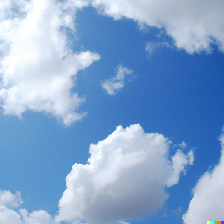

1/1 [==============================] - 0s 151ms/step
cloudy  :  0.25193658
rain  :  0.2572483
shine  :  0.23368806
sunrise  :  0.25712705


In [128]:
dall_e_weather_images_folder = "/content/drive/MyDrive/intro-to-AI/hw/data_mining_project/image_iden/dall-e_images"
img_path = os.listdir(dall_e_weather_images_folder)[0]
img_path = os.path.join(dall_e_weather_images_folder , img_path)

pred = weather_use.predict_image_with_vgg(
    img_path = img_path,
    display_image = True,
    
    )


for key , value in zip(pred.keys() , pred.values()):
  print(key , " : " , value)

# for p in pred[0]:
#   tag = p[1]
#   prob = p[2]
#   print(tag , " : " , prob)


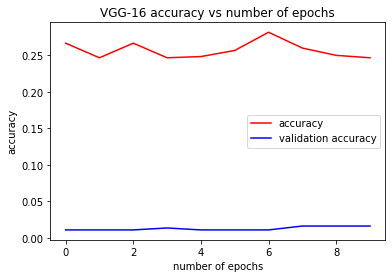

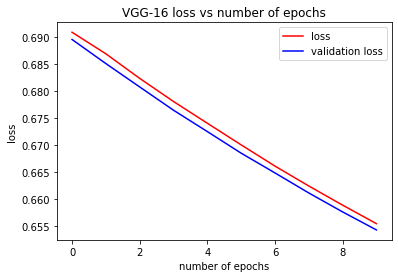

accuracy:  0.24666666984558105 , validation accuracy: 0.01600000075995922


In [129]:
acc , val_acc = our_plot(weather_use.vgg_history , title = "VGG-16")
print("accuracy: " , acc , ", validation accuracy:" , val_acc)